# Yapay Sinir Ağları (Artificial Neural Network - ANN)

* Lojistik regresyon, sınıflandırma problemleri için etkili bir algoritmadır. Ancak, problemin karmaşıklığı (non-linearity) arttığında yetersiz kalabilir ve başarı düzeyi sınırlı olabilir. Bu tür durumlar için modelin karmaşıklığını artırmak gerekebilir ve bunu yapmanın bir yolu, gizli katmanlar (hidden layers) eklemektir.
* Lojistik regresyona gizli katmanlar eklediğimizde, yapay sinir ağı (neural network) algoritmasını elde ederiz.
* Bu tür bir yapay sinir ağı algoritmasına "Yapay Sinir Ağı (Artificial Neural Network - ANN)" denir.

In [1]:
# kütüphaneler

In [2]:
import torch # pytorch
import torch.nn as nn # neaural network katmanlarını kullanabilmek için
from torch.autograd import Variable # gradient, türev hesabı için
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd # veriyi import etmek için
import numpy as np

from sklearn.model_selection import train_test_split # veriyi train ve test olarak ayıracağım

import matplotlib.pyplot as plt

## Problem Tanımı ve Veri Seti Hazırlama (Preprocess)

* MNIST veri seti, 28x28 piksel boyutunda siyah-beyaz (gray-scale) resimler içerir. Toplam piksel sayısı 28x28 = 784'tür.
* Bu veri setinde yer alan resimler el yazısıyla yazılmış rakam görsellerini içerir (0-9 arası rakamlar).
* Dolayısıyla, bu veri setinde 10 farklı sınıf bulunur, her sınıf bir rakamı temsil eder (0-9).
* Renk tonları, siyahtan (0) beyaza (255) kadar değişir, arada farklı gri tonları bulunur.
* Toplamda 785 sütun bulunur. İlk sütun, resmin sınıfını belirten etiketi (label) içerir. Diğer sütunlarda ise resmin her pikselinin değeri bulunur.

In [3]:
train = pd.read_csv(r"train.csv", dtype = np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
targets_numpy = train.label.values
targets_numpy[:5] # label sütunu

array([1., 0., 1., 4., 0.], dtype=float32)

In [5]:
# label sütunu dışındaki bütün değerleri (piksel değerleri) al ve normalize et
features_numpy = train.loc[:, train.columns != "label"].values / 255 # normalizasyon

In [6]:
# %20 test veri seti olsun
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                              targets_numpy,
                                                                              test_size = 0.2,
                                                                              random_state = 42)

In [7]:
# pytorch kütüphanesinde gradient hesabı (türev) yapabilmek ve bunları biriktirebilmek için 
# variable veri yapısına ihtiyacımız vardır. bunun için ilk önce tensor'lere dönüştürelim

In [8]:
# numpy -> tensor
featuresTrain = torch.from_numpy(features_train) # tensor
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # tensor

In [9]:
featuresTrain.shape # toplam resim/örnek sayısı (satır) : 33600
# 1 resimdeki toplam piksel sayısı 784 (28*28)

torch.Size([33600, 784])

In [10]:
# numpy -> tensor
featuresTest = torch.from_numpy(features_test) # tensor
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # tensor

* veri seti 33600 tane örnekten oluşsun
* batch_size (her grubun içerisindeki örnek sayısı) 100 ise 33600/100 = 336 tane grup vardır
* 1 epoch'ta 336 tane grup vardır (her grup 100 örnek içerir)
* dolayısıyla 1 epoch 336 iterasyondan oluşur.
* 29 tane epoch yaparsak 29 * 336 = 9744 tane iterasyon yapmalıyız

In [11]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000

# epoch sayısı = iterasyon sayısı / grup sayısı
num_epochs = n_iters / (len(features_train)/ batch_size)
num_epochs = int(num_epochs)
num_epochs

29

In [12]:
# Pytorch ile train ve test veri setlerini oluşturalım
train = TensorDataset(featuresTrain, targetsTrain) # pikseller, sınıf
test = TensorDataset(featuresTest, targetsTest)

In [13]:
# data loader
# veri setini batch_size'a göre düzenliyor
# pytorch'ta training yapabilmek için gerekli olan veri tipine dönüştürür
# DataLoader, veri kümesini mini gruplar halinde işlemek için kullanılan bir yardımcı sınıftır.
# Bu, eğitim verilerini mini gruplar halinde yüklemek için kullanılır.
# batch_size: Bu, her bir mini grup (batch) için kaç örnek alınacağını belirtir.
# Mini gruplar, modelin eğitim sırasında güncellemelerini hesaplamak için kullanılır.
# shuffle: Bu, veri kümesinin karıştırılıp karıştırılmayacağını belirtir
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

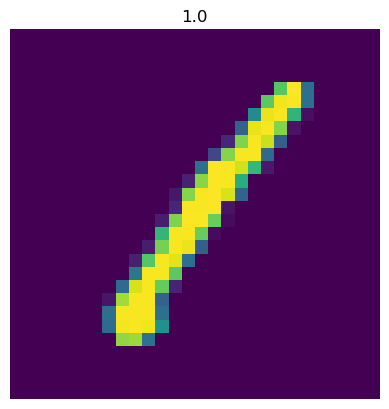

In [14]:
# resimi görselleştirelim
plt.imshow(features_numpy[0].reshape(28,28)) # 0. satırdaki örneği 28,28 görselleştirelim
plt.axis("off")
plt.title(str(targets_numpy[0])) # label, sınıf
plt.savefig("graph.png") # resimi kaydedelim
plt.show()

## Yapay Sinir Ağı Modelinin Kurulması

* Yapay sinir ağı modelimiz, 3 adet gizli katman (hidden layer) içerir.
* Her bir gizli katman farklı aktivasyon fonksiyonları kullanır, bu fonksiyonlar ReLU, Tanh ve ELU'dur.

* 28*28'lik bir resim var, 28*28 = 784 pikselden oluşur.
* bu resim flatten hale getirilir. vektör oluşur. bu vektör 784 satır, 1 sütun
* 784 piksel olduğundan input boyutu (input_dim) 784 olur
* init fonksiyonunda layer ve aktivasyon fonksiyonları tanımlamır
* 3 tane hidden layer eklenecek ve boyutları 150 node olacak
* output layer ise 10 tane sınıf olduğundan 10 tane node
* karmaşıklığı artırabilmek için aktivasyon fonksiyonlarını ekleyelim
* 1. hidden layer - relu - 2. hidden - tanh - 3. hidden - elu - output layer

forward ile belirlenen layer ve aktivasyon fonksiyonlarını birbirine bağlanır.

* output olasılıksal bir değer döner (y_pred), bunu loss fonksiyonunun içerisine koyar. 
* loss(y_pred, y_real) hesaplanır
* en başa dönülür ve gradient hesaplanır, back propagation işlemi gerçekleiştirilir.

In [15]:
# ANNModel isimli bir sınıf oluşturdum:
class ANNModel(nn.Module): # ANNModel, pytorch'un nn.Module'ünü inherit eder
    
    # ANNModel sınıfının input parametreleri: input_dim: 784, hidden_dim: 150, output_dim: 10
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super(ANNModel, self).__init__() # ANNModel, nn.Module'den inherit eder
        # ANNModel, inherit edebilmesi için nn.Module'ün init fonksiyonunu çağırır
        # nn.Module'ün fonksiyonlarını kullanabiliriz
        
        # 1. lineer fonksiyonu 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) # hidden layer
        # Karmaşıklık (Non-linearity) 1
        self.relu1 = nn.ReLU() # aktivasyon fonksiyonu
        
        # 2. lineer fonksiyonu 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Karmaşıklık (Non-linearity) 2
        self.tanh2 = nn.Tanh()
        
        # 3. lineer fonksiyonu 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Karmaşıklık (Non-linearity) 3
        self.elu3 = nn.ELU()
        
        # output
        # 4. lineer fonksiyonu 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim) # output layer
        
    
    def forward(self, x): # x, 784 tane pikseldir.
        # 1. lineer fonksiyonu
        out = self.fc1(x) # hidden layer
        # Non - linearity 1
        out = self.relu1(out) # aktivasyon fonksiyonu
        
        # 2. lineer fonksiyonu
        out = self.fc2(out) # hidden layer
        # Non - linearity 2
        out = self.tanh2(out) # aktivasyon fonksiyonu
        
        # 3. lineer fonksiyonu
        out = self.fc3(out) # hidden layer
        # Non - linearity 3
        out = self.elu3(out) # aktivasyon fonksiyonu
        
        # 4. lineer fonksiyonu
        out = self.fc4(out) # output layer
        # y_pred
        # softmax fonksiyonu, cross entropy loss'un içerisinde bulunur
        
        return out # olasılıksal tahmini değer

In [16]:
# boyutlar tanımlanır
input_dim = 28*28 # resmin toplam piksel sayısı 28*28
# hidden layer sayısı ve hidden layer'in içerisindeki node (cell) sayısı hiperparametredir
hidden_dim = 150 # node (cell) sayısı
output_dim = 10 # 10 tane sınıfa sahip olduğum için (0-9)

In [17]:
# ANN oluştur
model = ANNModel(input_dim, hidden_dim, output_dim)

In [18]:
# cross entropy loss
# softmax fonksiyonu, cross entropy loss'un içerisinde bulunur
error = nn.CrossEntropyLoss()

In [19]:
# SGD Optimizer
learning_rate = 0.02

# parametreleri günceller
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

* train için verilerimiz var
* train işlemini gerçekleştirirken backpropagation yöntemiyle gradient'leri hesaplıyoduk
* ve bu gradient'leri biriktirmek için variable tanımlamalıyız
* input'u (resim/pikseller ve label'lar/sınıf/etiket) variable içerisine atacağız
* Variable(input)

* parametreleri öğreneceğiz
* parametreleri güncellemek zorundayız. 
* ilk olarak geçiçi değerler atanır sonra güncellenir
* ilk iterasyonda parametrelerin değeri olmadığından ilk değer atamalıyız
* optimizer'ın içerisinde bulunan parametrelere sıfır değerini atarız yani gradient'lere 0 değerini atarız
* zero_gradient

* her defasında gradient'leri sıfır yapmamızın sebebi back propagation kısmında backward fonksiyonu kullanılır.
* backward fonksiyonunun yaptığı şey Variable'ları kullanarak gradient'leri biriktirmektir.
* gradient'leri her seferinde sıfırlamazsak bir önceki adımdaki gradientler toplanır, biriktirilir ve yanlış hesaplanmış olur.
* gradient'ler sıfırlandığında onları kaybetmiyoruz, backward fonksiyonunda gradient'ler Variable içerisinde depolanır, biriktirilir. bu nedenle sıfırlama her adımda olur
* backward fonksiyonu sayesinde gradient'leri biriktirebiliyoruz.

* modeli eğitelim
* model(train)

* loss hesabı yapacağız (cross entropy)

* backpropagation yapılır
* türev alarak geriye doğru gidilir (backward)
* gradient'ler hesaplandı

* gradient'ler (türevler) hesaplandıktan sonra parametreleri güncellemeliyiz
* learning rate sabit bir değer ve weight biliniyor
* w = w - lr * gradient (gradient'leri backward sonucunda bulduk)
* parametreleri güncellemek için optimizer'ın step metodunu çağırırız
* step()

In [20]:
# training işlemi for döngüsünde epoch sayısı kadar devam eder ve gerçekleştirilir

* count 50'nin katı olduğunda prediction (tahmin) işlemini gerçekleştireceğiz
* test veri setini kullanarak tahmin işlemini gerçekleştireceğiz
* training aşamasında hemde prediction işlemi paralel olarak gerçekleştirelim
* prediction:
    * variable tanımlanır: variable(test resimleri)
    * gradient'leri hesaplamayacağım çünkü prediction yapıyorum elimdeki parametreleri test ediyorum
    * train ile parametre değerleri belirlendi bu parametreler kullanılarak prediction işlemi gerçekleştireceğim
    * model(test)
    * model'e test veri seti verilir ve çıktı olarak tahmini değerler bulunur
    * loss hesabı yapmayacağım çünkü training aşamasında loss değeri hesaplanır
    * accuracy değerine bakılır.
    * özetle input'lar kullanılabilir hale getirilir yani variable tanımlanır, daha sonra prediction gerçekleştirilir. Accuracy değeri hesaplanır.

In [21]:
# ANN modeli eğitelim

count = 0 # her 50 adımda prediction işlemi gerçekleştirilecek
loss_list = [] # hata değerleri
iteration_list = []
accuracy_list = [] # prediction sonunda ortaya çıkan accuracy doğruluk değerleri

for epoch in range(num_epochs): # tüm train veri seti 29 kere train edilecek
    for i, (images, labels) in enumerate(train_loader): # train_loader: variable
        
        # resimler ve resimlere karşılık gelen label'lar var
        train = Variable(images.view(-1, 28*28)) # train edilecek veri
        labels = Variable(labels) # train edilecek veriye karşılık gelen sınıflar
        
        # optimizer'in içerisindeki gradient'ler sıfırlanır
        optimizer.zero_grad()
        
        # forward propagation
        # model eğitilir ve tahmini değerler çıktı olarak üretilir: y_pred
        outputs = model(train)
        
        # cross entropy loss (içerisinde softmax bulunur)
        # tahmin edilen değerler (y_pred) ile gerçek değerler 
        loss = error(outputs, labels)
        
        # gradients hesaplanır
        # loss değerini kullanarak back propagation işlemi gerçekleştirilir.
        # ve gradient değerleri bulunur.
        loss.backward()
        
        # parametreler güncellenir
        # gradient değerleri hesaplanmıştı
        # parametreler, learning rate ve gradient'lere göre güncellenir
        optimizer.step()
        
        # bir training aşaması biter
        
        count += 1
        
        # count 50'nin katı olduğunda prediction (tahmin) işlemini gerçekleştireceğiz
        # test veri setini kullanarak tahmin işlemini gerçekleştireceğiz
        if count % 50 == 0:
            # Accuracy
            correct = 0 # kaç tane veri doğru tahmin edildi
            total = 0 # kaç tane veri test edildi
            
            # test veri seti
            for images, labels in test_loader:
                # resimler ve resimlere karşılık gelen sınıflar
                
                # bu resimleri kullanarak test isimli bir variable oluşturdum
                test = Variable(images.view(-1, 28*28))
                
                # forward propagation
                # test veri setini modele input olarak verilir
                # ve prediction işlemi gerçekleşir
                # output olarak tahmini değerler üretilir
                outputs = model(test) # model tahmin eder
                # outputs (tahmini değerler), olasılıksal bir değerdir
                # 10 farklı sınıf olduğundan 10 tane olasılıksal değer elde edilir
                
                # her bir resim için 10 tane olan tahmini olasılık değerlerinden 
                # en büyük olasılık değeri seçilir ve buna karşılık gelen sınıf atanır.
                predicted = torch.max(outputs.data, 1)[1]
                # 10 tane değerin içerisinden en büyük olanını alıyoruz
                # en büyük olan, olasılık değeri en yüksek olan sınıf seçilir.
                
                # toplam tahmin edilen veri
                total += len(labels)
                
                # kaç tane veri doğru tahmin edildi
                correct += (predicted == labels).sum() # doğru tahmin edilen veri sayısı
                
            # Accuracy
            accuracy = 100 * correct / float(total)
            
            # loss, iteration ve accuracy
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        # her 500'de bir 
        if count % 500 == 0:
            print("Iteration: {} Loss: {} Accuracy: {} %".format(count, loss.data, accuracy))

Iteration: 500 Loss: 0.7707474231719971 Accuracy: 80.41666412353516 %
Iteration: 1000 Loss: 0.464295893907547 Accuracy: 87.53571319580078 %
Iteration: 1500 Loss: 0.22499513626098633 Accuracy: 89.54762268066406 %
Iteration: 2000 Loss: 0.28686070442199707 Accuracy: 90.67857360839844 %
Iteration: 2500 Loss: 0.3188752830028534 Accuracy: 91.9047622680664 %
Iteration: 3000 Loss: 0.11533597111701965 Accuracy: 92.5 %
Iteration: 3500 Loss: 0.2402036488056183 Accuracy: 93.4047622680664 %
Iteration: 4000 Loss: 0.06156260892748833 Accuracy: 93.92857360839844 %
Iteration: 4500 Loss: 0.2923550009727478 Accuracy: 94.41666412353516 %
Iteration: 5000 Loss: 0.10613932460546494 Accuracy: 94.73809814453125 %
Iteration: 5500 Loss: 0.18491365015506744 Accuracy: 94.8452377319336 %
Iteration: 6000 Loss: 0.17496225237846375 Accuracy: 95.0952377319336 %
Iteration: 6500 Loss: 0.09310413151979446 Accuracy: 95.42857360839844 %
Iteration: 7000 Loss: 0.09780281782150269 Accuracy: 95.69047546386719 %
Iteration: 7500 

İterasyon sayısı arttıkça loss değerleri azalır ve accuracy değerleri ise artar.

100 resimden 96 tanesini doğru tahmin edebiliyorum demektir.

In [22]:
# görselleştirme

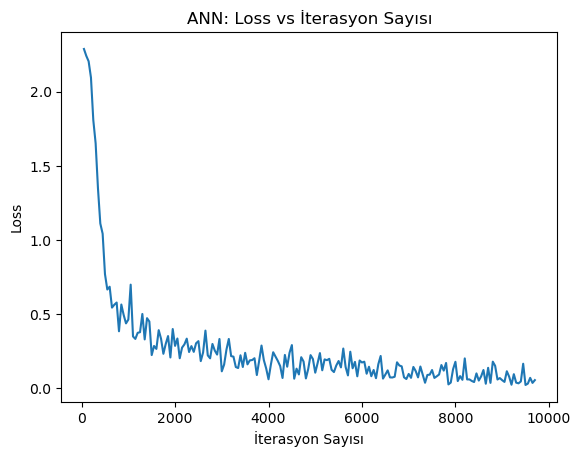

In [23]:
# Loss
plt.plot(iteration_list, loss_list)
plt.xlabel("İterasyon Sayısı")
plt.ylabel("Loss")
plt.title("ANN: Loss vs İterasyon Sayısı")
plt.show()

iterasyon sayısı arttıkça loss değeri azalmıştır. loss değerinin azalması modelin öğrendiği anlamına gelir. weight ve bias parametrelerinin güncellendiği anlamına gelir

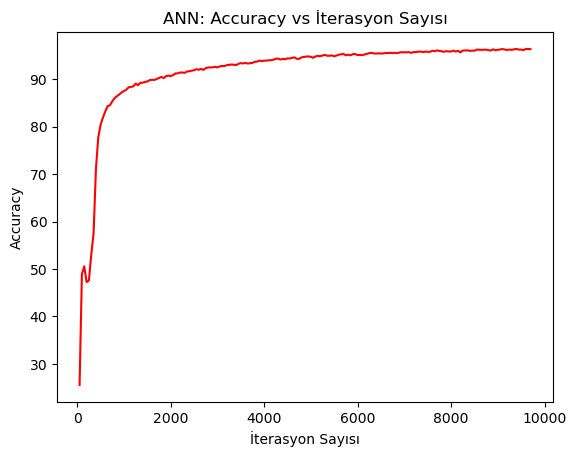

In [24]:
# Accuracy
plt.plot(iteration_list, accuracy_list, color="red")
plt.xlabel("İterasyon Sayısı")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs İterasyon Sayısı")
plt.show()

Accuracy değerinin arttığı gözlemlenmiştir.

lojistik regresyona göre başarım artmıştır. model karmaşıklığı arttıkça başarıda artmış olur.